In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext.legacy
from torchtext import datasets

from torch.utils.tensorboard import SummaryWriter

import re
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt


import spacy

import random
import os, pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score

## Load Tweets Dataset

In [ ]:
tweets = pd.read_csv('/content/session6/tweets.csv', encoding = 'latin-1')

In [ ]:
tweets.head()

,tweets,labels
0,Obama has called the GOP budget social Darwini...,1
1,"In his teen years, Obama has been known to use...",0
2,IPA Congratulates President Barack Obama for L...,0
3,RT @Professor_Why: #WhatsRomneyHiding - his co...,0
4,RT @wardollarshome: Obama has approved more ta...,1


In [ ]:
tweets.labels.value_counts()

0    931
1    352
2     81
Name: labels, dtype: int64

[Text(0.5, 0, 'Labels')]

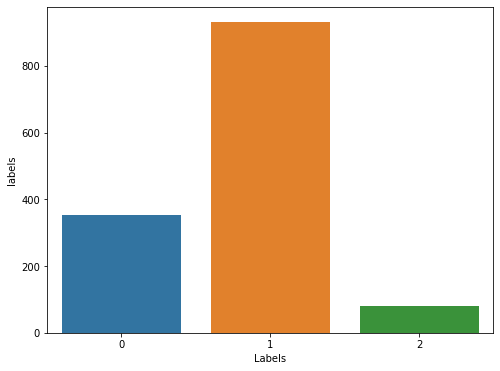

In [ ]:
fig = plt.figure(figsize=(8,6))

ax = sns.barplot(x=tweets['labels'].unique(), y=tweets['labels'].value_counts())

ax.set(xlabel = 'Labels')

### Data is imbalanced and should be made balanced

## Data cleanup, Train Test Split and prepare Vocab

In [ ]:
train, test = train_test_split(tweets, test_size= .3, random_state= 42)

In [ ]:
train.reset_index(drop=True), test.reset_index(drop=True)

(                                                tweets  labels
 0    RT @markknoller: Saul says Pres Obama "will do...       1
 1    RT @Drudge_Report: Obama setting up Supreme Co...       1
 2    @sweetbay That was Paul Ryan's budget. How did...       1
 3    RT @GEsfandiari: "Obama signaled US would acce...       1
 4                  RT @anna12061: Another Obama Buddy!       0
 ..                                                 ...     ...
 949  #WhatsRomneyHiding Obama released his tax retu...       0
 950                #KimKardashiansNextBoyFriend Obama!       0
 951  RT @larryeldershow: Spike Lee said he dislikes...       0
 952  RT @pourmecoffee: White House Easter Egg Roll ...       1
 953  #WhatsRomneyHiding His relationship with Vera ...       0
 
 [954 rows x 2 columns],
                                                 tweets  labels
 0    RT @ohgirlphrase: American kid "You're from th...       0
 1    Examiner Editorial: Obama's budget, not Ryan's...       0
 2    Obama o

In [ ]:
def tweet_clean(text):
  text = re.sub(r'[^A-Za-z0-9_-]+', ' ', text)
  text = re.sub(r'https?:/\/\S+', ' ', text)

  return(text.strip())

In [ ]:
nlp = spacy.load('en', disable = ['parser', 'tagger', 'ner'])
def tokenizer(s):
  return [w.text.lower() for w in nlp(tweet_clean(s))]

In [ ]:
TEXT = torchtext.legacy.data.Field(tokenize=tokenizer, lower=True, init_token= '<sos>', eos_token= '<eos>')

LABEL = torchtext.legacy.data.LabelField(tokenize = tokenizer)

# english = torchtext.legacy.data.Field(tokenize=tokenizer_end, lower=True, init_token= '<sos>', eos_token= '<eos>')

In [ ]:
datafields = [('tweets', TEXT), ('labels', LABEL)]

### Split and save datasets

In [ ]:
train.to_csv('session6/train.csv', index=False)
test.to_csv('session6/test.csv', index=False)

In [ ]:
trn, tst = torchtext.legacy.data.TabularDataset.splits(path='/content/session6',
                                                       train = 'train.csv',
                                                       test = 'test.csv',
                                                       format = 'csv',
                                                       skip_header = True,
                                                       fields = datafields
                                                       )

In [ ]:
print(f'Number of training examples: {len(trn)}')
print(f'Number of testing examples: {len(tst)}')

Number of training examples: 954
Number of testing examples: 410


In [ ]:
vars(trn.examples[0])

{'labels': '1',
 'tweets': ['rt',
  'markknoller',
  'saul',
  'says',
  'pres',
  'obama',
  'will',
  'do',
  'anything',
  'to',
  'distract',
  'americans',
  'from',
  'his',
  'failed',
  'economic',
  'record',
  'incl',
  'unemployment',
  'higher',
  'gas',
  'prices']}

In [ ]:
TEXT.build_vocab(trn, max_size = 10000,
                #  vectors = "glove.6B.100d",
                min_freq = 2 
                )

LABEL.build_vocab(trn) 

In [ ]:
print(TEXT.vocab.freqs.most_common(50))

[('obama', 955), ('the', 485), ('rt', 433), ('t', 386), ('to', 343), ('co', 331), ('http', 329), ('s', 269), ('you', 247), ('a', 230), ('of', 214), ('is', 201), ('with', 178), ('in', 171), ('do', 155), ('-', 155), ('that', 150), ('on', 143), ('i', 141), ('and', 139), ('he', 137), ('for', 129), ('kid', 125), ('whatsromneyhiding', 122), ('his', 115), ('so', 112), ('like', 108), ('from', 102), ('romney', 92), ('president', 88), ('have', 88), ('it', 83), ('go', 80), ('re', 73), ('not', 72), ('has', 70), ('at', 70), ('american', 68), ('cool', 66), ('can', 63), ('we', 63), ('uk', 62), ('ohhh', 62), ('tea', 62), ('queen', 62), ('british', 62), ('mcdonalds', 62), ('gop', 61), ('edshow', 60), ('ohgirlphrase', 58)]


In [ ]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', '<sos>', '<eos>', 'obama', 'the', 'rt', 't', 'to', 'co']


In [ ]:
print(LABEL.vocab.itos)

['0', '1', '2']


In [ ]:
print(LABEL.vocab.stoi)

defaultdict(None, {'0': 0, '1': 1, '2': 2})


## Build Model class

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size):
    super(Encoder, self).__init__()

    self.embedding = nn.Embedding(input_size, embedding_size)
    self.rnn = nn.LSTM(embedding_size, hidden_size)

  def forward(self,x):
    # x shape: (seq_length, N)
    embedding = self.embedding(x)

    # embedding shape: (seq_length, N, embedding_size)
    output, (hidden, cell) = self.rnn(embedding)

    return output, hidden, cell

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, c_state_size, output_size):
      super(Decoder, self).__init__()

      self.rnn = nn.LSTM(input_size, hidden_size)
      self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):

      outputs, (hidden, cell) = self.rnn(x,(hidden, cell)) 
      predictions = self.fc(hidden)

      return predictions, hidden, cell


class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder):
    super(Seq2Seq, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, source):

    op, hidden, cell = self.encoder(source)

    # Grab start token
    x = op

    predictions, d_hidden, d_cell = self.decoder(x, hidden, cell)
   
    best_pred= predictions.squeeze(0)

    return best_pred


### Initialize Training Parameters

---



In [ ]:
## Training starts -

# Training hyperparameters
num_epochs = 10
learning_rate = 0.001
batch_size = 8

# Model hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size_encoder = len(TEXT.vocab)
input_size_decoder = 64 # Hidden dimention for output
output_size = len(LABEL.vocab)
encoder_embedding_size = 32

cell_state_size = 64
hidden_size = 64
num_layers = 1

# Tensorboard
# writer = SummaryWriter(f'runs/loss_plot')
# step = 0

## Create Data Loaders

In [ ]:
# Get iterators
train_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits(
    (trn, tst),
    batch_size = batch_size,
    sort_within_batch = True,
    sort_key = lambda x: len(x.tweets),
    device= device)


## Initialize Models, Optimizer and define Criterion

In [ ]:
encoder_net = Encoder(input_size_encoder, encoder_embedding_size, 
                      hidden_size).to(device)

decoder_net = Decoder(input_size_decoder, hidden_size, cell_state_size, output_size).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)


optimizer = optim.Adam(model.parameters(), lr = learning_rate)

pad_idx = TEXT.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(device)

In [ ]:
# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch_idx, batch in enumerate(train_iterator):

        inp_data = batch.tweets.to(device)
        target = batch.labels.to(device)

        # output = model(inp_data, target)
        output = model(inp_data)
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
               
        # # convert to 1D tensor
        # predictions = model(batch.sentence).squeeze(1)
        
        # compute the loss
        # loss = criterion(predictions, batch.label.long())
        loss = criterion(output, target)        
        
        # compute the binary accuracy
        acc = binary_accuracy(output, target)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # clip weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
                   
            # convert to 1d tensor
            # predictions = model(batch.sentence).squeeze(1)
            inp_data = batch.tweets.to(device)
            target = batch.labels.to(device)
            output = model(inp_data)
            # output = model(inp_data, target)
            
            # compute loss and accuracy
            loss = criterion(output, batch.labels)
            acc = binary_accuracy(output, batch.labels)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
N_EPOCHS = 10

best_test_loss = float('inf')

trn_loss = [] 
trn_acc = []
tst_loss = [] 
tst_acc = [] 

for epoch in range(N_EPOCHS):
    
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    trn_loss.append(train_loss)
    trn_acc.append(train_acc*100)
    
    # evaluate the model
    test_loss, test_acc = evaluate(model, test_iterator, criterion)
    tst_loss.append(test_loss)
    tst_acc.append(test_acc*100)
    
    # # save the best model
    # if test_loss < best_test_loss:
    #     best_test_loss = test_loss
    #     torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'Epoch: {epoch+1}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}% \n')

Epoch: 1
	Train Loss: 0.050 | Train Acc: 72.08%
	 Val. Loss: 0.614 |  Val. Acc: 68.27% 

Epoch: 2
	Train Loss: 0.073 | Train Acc: 71.67%
	 Val. Loss: 0.330 |  Val. Acc: 71.15% 

Epoch: 3
	Train Loss: 0.026 | Train Acc: 72.50%
	 Val. Loss: 0.330 |  Val. Acc: 72.36% 

Epoch: 4
	Train Loss: 0.034 | Train Acc: 71.88%
	 Val. Loss: 0.455 |  Val. Acc: 69.71% 

Epoch: 5
	Train Loss: 0.042 | Train Acc: 72.29%
	 Val. Loss: 0.480 |  Val. Acc: 70.19% 

Epoch: 6
	Train Loss: 0.026 | Train Acc: 72.40%
	 Val. Loss: 0.339 |  Val. Acc: 72.84% 

Epoch: 7
	Train Loss: 0.016 | Train Acc: 72.40%
	 Val. Loss: 0.357 |  Val. Acc: 72.60% 

Epoch: 8
	Train Loss: 0.016 | Train Acc: 72.60%
	 Val. Loss: 0.433 |  Val. Acc: 72.12% 

Epoch: 9
	Train Loss: 0.002 | Train Acc: 72.92%
	 Val. Loss: 0.408 |  Val. Acc: 73.08% 

Epoch: 10
	Train Loss: 0.013 | Train Acc: 72.71%
	 Val. Loss: 0.482 |  Val. Acc: 71.15% 



Text(0.5, 1.0, 'Accuracy')

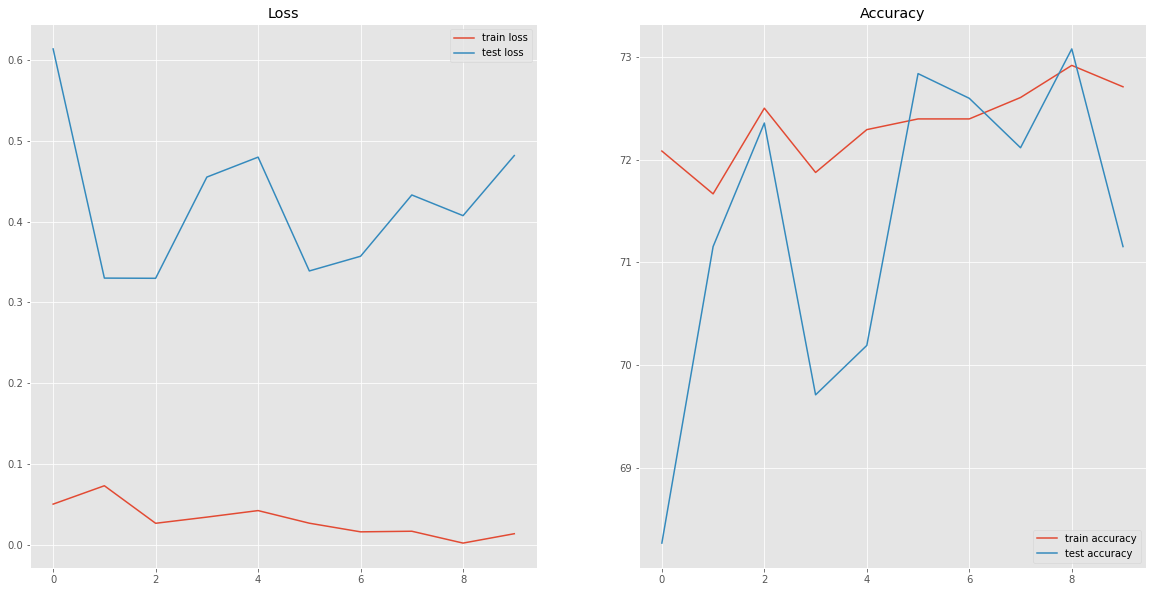

In [ ]:
plt.style.use('ggplot')

fig, axs = plt.subplots(1,2,figsize=(20,10))

axs[0].plot(trn_loss, label = 'train loss')
axs[0].plot(tst_loss, label = 'test loss')
axs[0].legend(loc="upper right")
axs[0].set_title("Loss")

axs[1].plot(trn_acc,  label = 'train accuracy')
axs[1].plot(tst_acc,  label = 'test accuracy')
axs[1].legend(loc="lower right")
axs[1].set_title("Accuracy")

In [ ]:
def test_model(sentence):
  tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
  indexed = [TEXT.vocab.stoi[t] for t in tokenized]
  tensor = torch.LongTensor(indexed)
  tensor = tensor.unsqueeze(1).to(device)

  model.eval()
  prediction = model(tensor)
  return( ["negative", "neutral", "positive"][prediction.argmax()] )

In [ ]:
sentence = test['tweets'].iloc[78]
label = test['labels'].iloc[78]
test_model(sentence), sentence, ["negative", "neutral", "positive"][label]

('positive',
 'Poor Warin\' Orin Hatch on a tear that Obama is "going to throw the Mormon Church" at Mitt #notactuallyconfirmed #mittless',
 'negative')

In [ ]:
sentence = 'RT @WhatTheFFacts: In his teen years, Obama has been known to use marijuana and cocaine.'
label = 0
test_model(sentence), sentence, ["negative", "neutral", "positive"][label]

('negative',
 'RT @WhatTheFFacts: In his teen years, Obama has been known to use marijuana and cocaine.',
 'negative')